# Dreambooth

The goal of this tutorial is to get demo how to fine tune an image generation model

In [1]:
from AIsaac.all import *
import fastcore.all as fc

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, PretrainedConfig,CLIPTextModel
from accelerate import Accelerator
import xformers # May need dev version
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

from PIL import Image
import itertools, math
from pathlib import Path
from itertools import zip_longest

from IPython.display import clear_output


/home/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
def decode(tokenizer, tokens, start_after='<|startoftext|>', end_at='<|endoftext|>'):
    _decoded = ds.tokenizer.decode(tokens)
    return _decoded[len(start_after):_decoded.find(end_at)].strip()

In [3]:
denorm = UnNormalize([.5],[.5])

## DataLoaders

In [4]:
xmean,xstd = 0.5, 0.5
@inplace
def transformi(b): 
    b['image'] = [(TF.to_tensor(TF.resize(o,512))-xmean)/xstd for o in b['image']]
    b['label'] = ['a photo of sks dog' for _ in b['label']]

dd = load_dataset("iflath/DogDreamBooth").with_transform(transformi)

Found cached dataset imagefolder (/home/.cache/huggingface/datasets/iflath___imagefolder/iflath--DogDreamBooth-fe88f623b33d9619/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 2/2 [00:00<00:00, 417.43it/s]


In [5]:
dls = DataLoaders.from_dataset_dict(dd,1)

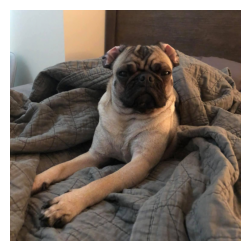

In [6]:
show_images(denorm(fc.first(dls.train)[0]))

## Data Augmentation

In [7]:
pretrained_model="CompVis/stable-diffusion-v1-4" 

In [8]:
img_tfms = transforms.Compose([transforms.RandomCrop(512),transforms.Normalize([0.5], [0.5])])

tokenizer = AutoTokenizer.from_pretrained(pretrained_model,subfolder="tokenizer",revision=None,use_fast=False,)
def lbl_tfms(yb,tokenizer=tokenizer):
    out = tokenizer(yb,truncation=True, padding="max_length",max_length=tokenizer.model_max_length,return_tensors="pt",)
    return out.input_ids
BatchAugmentationCB([img_tfms,lbl_tfms])

## Model

In [9]:
class DreamBoothModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet", revision=None)
        self.text_encoder = CLIPTextModel.from_pretrained(pretrained_model, subfolder="text_encoder", revision=None)
        
    def forward(self,x):        
        encoder_hidden_states = self.text_encoder(x[1])[0]
        return self.unet(x[5], x[4], encoder_hidden_states).sample.float()

## Training

In [10]:
class DreamBoothTrainCB(AccelerateCB):
    def before_fit(self, trainer):
        '''Wraps model, opt, data in accelerate'''
        trainer.model,trainer.opt,trainer.dls.train,trainer.dls.valid = self.acc.prepare(
            trainer.model, trainer.opt, trainer.dls.train, trainer.dls.valid)
        
        trainer.noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model, subfolder="scheduler")
        trainer.vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae", revision=None)        
        trainer.vae.to(self.acc.device, dtype=torch.float16)
        
    def before_batch(self,trainer):
        trainer.batch = fc.L(trainer.batch)
        trainer.batch.append(trainer.vae.encode(trainer.batch[0].float().to(dtype=torch.float16)).latent_dist.sample() * trainer.vae.config.scaling_factor) #latents 2
        trainer.batch.append(torch.randn_like(trainer.batch[2]).float()) #noise 3
        trainer.batch.append(torch.randint(0, trainer.noise_scheduler.config.num_train_timesteps, (trainer.batch[2].shape[0],), device=trainer.batch[2].device).long()) # timesteps 4
        trainer.batch.append(trainer.noise_scheduler.add_noise(trainer.batch[2], trainer.batch[3], trainer.batch[4])) # noisy latents 5
    
    def predict(self,trainer): trainer.preds = trainer.model(trainer.batch)
    def get_loss(self,trainer): trainer.loss = trainer.loss_func(trainer.preds,trainer.batch[3])
        
    def backward(self,trainer): 
        self.acc.backward(trainer.loss)
        if self.acc.sync_gradients: self.acc.clip_grad_norm_(trainer.model.parameters(), 1.)
   
    def zero_grad(self,trainer): trainer.opt.zero_grad(set_to_none=True)

## Train

In [11]:
trainer = Trainer(dls,fc.bind(F.mse_loss,reduction="mean"),torch.optim.AdamW,DreamBoothModel(),
        callbacks=[DreamBoothTrainCB(),OneCycleSchedulerCB(),BatchAugmentationCB([img_tfms,lbl_tfms]),DeviceCB(),MetricsCB(),ProgressCB()])

In [12]:
trainer.fit(30,lr=5e-6)

,train,valid
0,0.086682,0.233463


,train,valid
1,0.124968,0.169722


,train,valid
2,0.208165,0.208089


,train,valid
3,0.078694,0.205701


,train,valid
4,0.165773,0.295136


,train,valid
5,0.106130,0.199840


,train,valid
6,0.126509,0.112402


,train,valid
7,0.029292,0.123749


,train,valid
8,0.119567,0.160713


,train,valid
9,0.125213,0.162252


,train,valid
10,0.086805,0.049010


,train,valid
11,0.105268,0.108813


,train,valid
12,0.150549,0.135261


,train,valid
13,0.158626,0.137863


,train,valid
14,0.203742,0.147054


,train,valid
15,0.047560,0.046376


,train,valid
16,0.156907,0.085324


,train,valid
17,0.103484,0.148134


,train,valid
18,0.102207,0.184763


,train,valid
19,0.110293,0.188989


,train,valid
20,0.136986,0.132820


,train,valid
21,0.074456,0.118982


,train,valid
22,0.094781,0.164899


,train,valid
23,0.172200,0.275375


,train,valid
24,0.063592,0.170107


,train,valid
25,0.083717,0.218156


,train,valid
26,0.119296,0.399601


,train,valid
27,0.091175,0.177607


,train,valid
28,0.153505,0.192420


,train,valid
29,0.087264,0.115518


In [13]:
output_dir="dreambooth/out"
uw_model = trainer.DreamBoothTrainCB.acc.unwrap_model(trainer.model)
pipeline = DiffusionPipeline.from_pretrained(
    pretrained_model,
    unet=uw_model.unet,
    text_encoder=uw_model.text_encoder,
    revision=None,
)
pipeline.save_pretrained(output_dir)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 38130.04it/s]
/home/python3.10/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


a photo of sks dog with a tennis ball


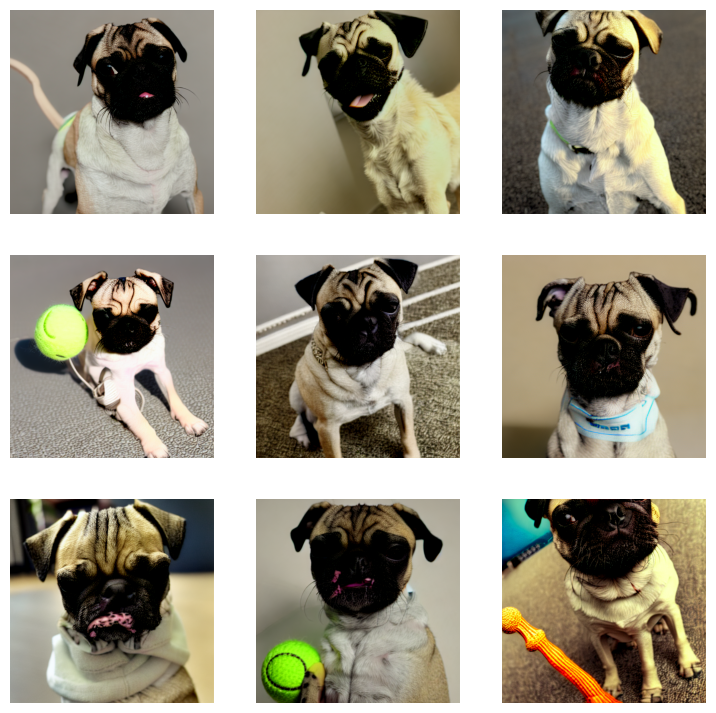

In [14]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(output_dir, torch_dtype=torch.float16).to("cuda")
prompt = "a photo of sks dog with a tennis ball"
    
images = [pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0] for i in range(9)]
clear_output()
print(prompt)
show_images(images)